In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from skimage.util import random_noise 
import cv2
import matplotlib.pyplot as plt


In [2]:
pip install torchattacks


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.2 MB/s 


In [3]:
import torchattacks
from torchattacks import PGD, FGSM, PGDL2

# Define Network

In [4]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1',n_classes=5):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features
        self.n_classes = n_classes # number of classes
        self.Y_ALL = []

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers-1)
            b = torch.randn(self.nf, 1, self.n_layers-1)
            final_K = torch.randn(self.nf, self.n_classes,1)
            final_b = torch.randn(self.n_classes, 1, 1)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers-1)
            b = torch.zeros(self.nf, 1, self.n_layers-1)
            final_K = torch.ones(self.nf, self.n_classes, 1)
            final_b = torch.zeros(self.n_classes, 1, 1)
        
        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)
        self.final_K = nn.Parameter(final_K, True)
        self.final_b = nn.Parameter(final_b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def getY_ALL(self):
        return self.Y_ALL

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
          
        self.Y_ALL = []
        
        for j in range(ini, end-1):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))
            self.Y_ALL.append(Y)
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput, self.K, self.b

In [5]:
class Res_Net(nn.Module):
    # General ODE: \dot{y} = \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True ,n_classes=10):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features
        self.n_classes = n_classes # number of classes

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers-1)
            b = torch.randn(self.nf, 1, self.n_layers-1)

        else:
            K = torch.ones(self.nf, self.nf, self.n_layers-1)
            b = torch.zeros(self.nf, 1, self.n_layers-1)

        
        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        for j in range(ini, end-1):
            Y = Y + self.h * self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j]))
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput, self.K, self.b

H-DNN

In [6]:
class Net_HDNN(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_HDNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        if net_type == 'H1_J1':
            self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        elif net_type == 'H1_J2':
            self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J2')
        elif net_type == 'Res_Net':
            self.hamiltonian = Res_Net(n_layers=n_layers, t_end=h * n_layers, nf=nf)
        else:
            raise ValueError("%s model is not yet implemented for MNIST" % net_type)
        self.fc_end = nn.Linear(nf*28*28, 10)
        self.nf = nf

    def forward(self, x):
        x = self.conv1(x)
        x,k,b = self.hamiltonian(x)
        x = x.reshape(-1, self.nf*28*28)
        output = self.fc_end(x)
        # output = F.log_softmax(x, dim=1)
        return output

Energy-based

In [7]:
def logcos(x):
    return x + torch.log(1+torch.exp(-2.0*x)) - torch.log(torch.tensor(2.0))
    # return torch.abs(x) + torch.log(1+torch.exp(-2.0*torch.abs(x))) - torch.log(torch.tensor(2.0))

In [8]:
def compute_H(y,K,b):
    dim = len(y.shape)
    y = y.transpose(1, dim-1)
    n_layers = K.shape[-1]
    H = torch.sum(logcos(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1])),dim-1)
    return H

In [9]:
def compute_all_H(y,K,b):
  H_ALL = []
  
  n_layers = K.shape[-1]
  
  for layer in range(n_layers):
    dim = len(y[layer].shape)
    current_state = y[layer]

    # print('state:',current_state.squeeze(2).shape)
    # print("K:",K[:, :, layer].transpose(0, 1).shape)
    # print('b:',b[:, 0, layer].shape)

    H_ALL.append(torch.sum(torch.log(torch.cosh(F.linear(
                current_state.squeeze(2), K[:, :, layer].transpose(0, 1), b[:, 0, layer]))),dim-1))
  
  return H_ALL

In [10]:
class Net_Energy(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_Energy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        if net_type == 'H1_J1':
            self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        elif net_type == 'Res_Net':
            self.hamiltonian = Res_Net(n_layers=n_layers, t_end=h * n_layers, nf=nf)
        self.fc_end = nn.Linear(28*28,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        x,K,b = self.hamiltonian(x)

        self.H = compute_H(x,K,b)

        all_states = self.hamiltonian.getY_ALL()

        self.H_ALL = compute_all_H(all_states,K,b)

        x = self.H.reshape(-1,28*28)
        output = self.fc_end(x)
        return output

## Energy of all layers

In [11]:
class Net_Energy_All_Layers(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_Energy_All_Layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        self.fc_end0 = nn.Linear((n_layers-1)*28*28,10)
        # self.fc_end1 = nn.Linear(128,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        x,K,b = self.hamiltonian(x)
        self.H = compute_H(x,K,b)

        all_states = self.hamiltonian.getY_ALL()
        self.H_ALL = compute_all_H(all_states,K,b)
        H_ALL_tensor = torch.stack(self.H_ALL,dim=1)
        x = H_ALL_tensor.reshape(-1,(n_layers-1)*28*28)
        output = self.fc_end0(x)
        # output = self.fc_end1(x)
        # output = F.log_softmax(x, dim=1)
        return output

## Unrolled Energy

In [12]:
class Net_Energy_Unroll(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1', pca_dim = 10):
        super(Net_Energy_Unroll, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        self.fc_end = nn.Linear(28*28,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        x= x.reshape(-1,self.nf,28*28)
        x,K,b = self.hamiltonian(x)
        self.H = compute_H(x,K,b)

        all_states = self.hamiltonian.getY_ALL()
        self.H_ALL = compute_all_H(all_states,K,b)

        x = self.H
        output = self.fc_end(x)
        # print("output:",output.shape)
        # output = F.log_softmax(x, dim=1)
        return output

## Energy + States

In [13]:
class Net_Energy_State(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_Energy_State, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        self.fc_end0 = nn.Linear((nf+n_layers-1)*28*28,10)
        # self.fc_end1 = nn.Linear(128,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        state,K,b = self.hamiltonian(x)
        self.H = compute_H(state,K,b)

        all_states = self.hamiltonian.getY_ALL()
        self.H_ALL = compute_all_H(all_states,K,b)
        H_ALL_tensor = torch.stack(self.H_ALL,dim=1)
        
        x = torch.cat((state,H_ALL_tensor),1)
        x = x.reshape(-1,(self.nf+n_layers-1)*28*28)
        output = self.fc_end0(x)
        # output = self.fc_end1(x)
        # output = F.log_softmax(x, dim=1)
        return output

# Load Data

In [14]:
use_cuda = torch.cuda.is_available()  # not no_cuda and
batch_size = 100 #100
test_batch_size = 1000
lr = 0.02
gamma = 0.8 #0.8
epochs = 10
seed = np.random.randint(0, 1000)
torch.manual_seed(seed)
np.random.seed(seed)

out = 1
n_classes = 10

In [15]:
# Define the net model
n_layers = 4
net_type = 'H1_J1'

h = 0.4
wd = 4e-3
alpha = 8e-3


device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 20, 'pin_memory': True} if use_cuda else {}


In [16]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data',download=True, train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Load Models

In [42]:
models = [torch.load('Ham_Net_9566.pkl'),torch.load('Res_Net_9640.pkl'),torch.load('Net_Energy_reg_1e-3.pkl'),
           torch.load('Net_Energy_all_layers_reg_9694.pkl')]

In [ ]:
models = [torch.load('Ham_Net_9566.pkl'),torch.load('Res_Net_9640.pkl'),torch.load('Net_Energy_reg_9247.pkl'),
           torch.load('Net_Energy_all_layers_reg_9694.pkl')]
# models = [torch.load('Ham_Net_9layers_9594.pkl'),torch.load('Res_Net_9layers_9474.pkl'),torch.load('Net_Energy_all_layers_9layers_9631.pkl')]

# Test with Noises

In [19]:
def test_gaussian(model, device, test_loader, out, var=0.05, count=0):
    model.eval()
    test_loss = 0
    correct = 0
    H = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data*0.3081 + 0.1307
            im_data = torch.tensor(random_noise(data, mode='gaussian', mean=0, var=var, clip=True)).float()
            im_data = (im_data-0.1307) / 0.3081
            output = model(im_data)
            if count > 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Variance:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            var, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9], target[0:9], pred[0:9]

In [ ]:
# for data, target in test_loader:
#       data, target = data.to(device), target.to(device)
#       data = data*0.3081 + 0.1307
#       im_data = torch.tensor(random_noise(data, mode='gaussian', mean=0, var=var, clip=True)).float()
#       im_data = (im_data-0.1307) / 0.3081
#       output = model(im_data)
#       break

In [20]:
def test_salt_pepper(model, device, test_loader, out, amount=0.05, count=0):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data*0.3081 + 0.1307
            im_data = torch.tensor(random_noise(data, mode='s&p', amount=amount)).float()
            im_data = (im_data-0.1307) / 0.3081
            output = model(im_data)
            if count > 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Amount:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            amount, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9], target[0:9], pred[0:9]

In [21]:
def test_gaussian_blur(model, device, out, kernel_size=3, sigma=(1,1), count=0):
    model.eval()
    test_loss = 0
    correct = 0
    H = []
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.GaussianBlur(kernel_size,sigma=sigma)
                        ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            im_data = data
            output = model(im_data)
            if count > 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Kernel_size:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            kernel_size, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9], target[0:9], pred[0:9]

In [ ]:
acc_gaussian_all=torch.load("acc_gaussian_all.pt")
exp_gaussian_all=torch.load("exp_gaussian_all.pt")
eng_gaussian_all=torch.load("eng_gaussian_all.pt")
tgt_gaussian_all=torch.load("tgt_gaussian_all.pt")
pre_gaussian_all=torch.load("pre_gaussian_all.pt")

In [ ]:
acc_salt_pepper_all=torch.load("acc_salt_pepper_all.pt")
exp_salt_pepper_all=torch.load("exp_salt_pepper_all.pt")
eng_salt_pepper_all=torch.load("eng_salt_pepper_all.pt")
tgt_salt_pepper_all=torch.load("tgt_salt_pepper_all.pt")
pre_salt_pepper_all=torch.load("pre_salt_pepper_all.pt")

In [ ]:
acc_gaussian_blur_all=torch.load("acc_gaussian_blur_all.pt")
exp_gaussian_blur_all=torch.load("exp_gaussian_blur_all.pt")
eng_gaussian_blur_all=torch.load("eng_gaussian_blur_all.pt")
tgt_gaussian_blur_all=torch.load("tgt_gaussian_blur_all.pt")
pre_gaussian_blur_all=torch.load("pre_gaussian_blur_all.pt")

In [ ]:
vars = np.linspace(0,1.0,11)
amounts = np.linspace(0,0.9,10)
kernel_sizes = np.linspace(1,17,9)


In [43]:
vars = np.linspace(0,1.0,11)
acc_gaussian_all = []
exp_gaussian_all = []
eng_gaussian_all = []
tgt_gaussian_all = []
pre_gaussian_all = []
count = 0
for model in models:
  print(model)
  count += 1
  acc_gaussian=[]
  exp_gaussian=[]
  eng_gaussian=[]
  tgt_gaussian=[]
  pre_gaussian=[]
  for var in vars:
    test_acc, examples, energy, target, pred = test_gaussian(model, device, test_loader, out, var, count)
    acc_gaussian.append(test_acc)
    exp_gaussian.append(examples)
    eng_gaussian.append(energy)
    tgt_gaussian.append(target)
    pre_gaussian.append(pred)
  acc_gaussian_all.append(acc_gaussian)
  exp_gaussian_all.append(exp_gaussian)
  eng_gaussian_all.append(eng_gaussian)
  tgt_gaussian_all.append(tgt_gaussian)
  pre_gaussian_all.append(pre_gaussian)

Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=6272, out_features=10, bias=True)
)
Variance:0.000 Average loss: 0.1380, Accuracy:  9566/10000 (95.66%)
Variance:0.100 Average loss: 1.5526, Accuracy:  5488/10000 (54.88%)
Variance:0.200 Average loss: 3.9460, Accuracy:  2427/10000 (24.27%)
Variance:0.300 Average loss: 5.6251, Accuracy:  1627/10000 (16.27%)
Variance:0.400 Average loss: 6.7257, Accuracy:  1346/10000 (13.46%)
Variance:0.500 Average loss: 7.5119, Accuracy:  1201/10000 (12.01%)
Variance:0.600 Average loss: 8.0054, Accuracy:  1176/10000 (11.76%)
Variance:0.700 Average loss: 8.4701, Accuracy:  1144/10000 (11.44%)
Variance:0.800 Average loss: 8.7939, Accuracy:  1118/10000 (11.18%)
Variance:0.900 Average loss: 8.9590, Accuracy:  1110/10000 (11.10%)
Variance:1.000 Average loss: 9.2934, Accuracy:  1077/10000 (10.77%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), str

In [ ]:
torch.save(acc_gaussian_all,"acc_gaussian_all.pt")
torch.save(exp_gaussian_all,"exp_gaussian_all.pt")
torch.save(eng_gaussian_all,"eng_gaussian_all.pt")

In [44]:
amounts = np.linspace(0,0.9,10)
acc_salt_pepper_all = []
exp_salt_pepper_all = []
eng_salt_pepper_all = []
tgt_salt_pepper_all = []
pre_salt_pepper_all = []
count = 0
for model in models:
  print(model)
  count+=1
  acc_salt_pepper = []
  exp_salt_pepper = []
  eng_salt_pepper = []
  tgt_salt_pepper = []
  pre_salt_pepper = []
  for amount in amounts:
    test_acc, examples, energy, target, pred = test_salt_pepper(model, device, test_loader, out, amount, count)
    acc_salt_pepper.append(test_acc)
    exp_salt_pepper.append(examples)
    eng_salt_pepper.append(energy)
    tgt_salt_pepper.append(target)
    pre_salt_pepper.append(pred)
  acc_salt_pepper_all.append(acc_salt_pepper)
  exp_salt_pepper_all.append(exp_salt_pepper)
  eng_salt_pepper_all.append(eng_salt_pepper)
  tgt_salt_pepper_all.append(tgt_salt_pepper)
  pre_salt_pepper_all.append(pre_salt_pepper)

Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=6272, out_features=10, bias=True)
)
Amount:0.000 Average loss: 0.1380, Accuracy:  9566/10000 (95.66%)
Amount:0.100 Average loss: 0.2549, Accuracy:  9160/10000 (91.60%)
Amount:0.200 Average loss: 0.8600, Accuracy:  7095/10000 (70.95%)
Amount:0.300 Average loss: 2.2236, Accuracy:  4347/10000 (43.47%)
Amount:0.400 Average loss: 4.0430, Accuracy:  2467/10000 (24.67%)
Amount:0.500 Average loss: 5.8811, Accuracy:  1614/10000 (16.14%)
Amount:0.600 Average loss: 7.5591, Accuracy:  1280/10000 (12.80%)
Amount:0.700 Average loss: 9.0722, Accuracy:  1128/10000 (11.28%)
Amount:0.800 Average loss: 10.2526, Accuracy:  1063/10000 (10.63%)
Amount:0.900 Average loss: 11.2324, Accuracy:  1029/10000 (10.29%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): Res_Net(
    (act): Tanh()
  )
  (fc_end)

In [45]:
sigmas = []
sigma_range = np.linspace(1,10,10)
kernel_sizes = np.linspace(1,17,9)
acc_gaussian_blur_all = []
exp_gaussian_blur_all = []
eng_gaussian_blur_all = []
tgt_gaussian_blur_all = []
pre_gaussian_blur_all = []
count = 0
for model in models:
  print(model)
  count+=1
  acc_gaussian_blur = []
  exp_gaussian_blur = []
  eng_gaussian_blur = []
  tgt_gaussian_blur = []
  pre_gaussian_blur = []
  for kernel_size in kernel_sizes:
    test_acc, examples, energy, target, pred = test_gaussian_blur(model, device, out, kernel_size=kernel_size, sigma=7, count=count)
    acc_gaussian_blur.append(test_acc)
    exp_gaussian_blur.append(examples)
    eng_gaussian_blur.append(energy)
    tgt_gaussian_blur.append(target)
    pre_gaussian_blur.append(pred)
  acc_gaussian_blur_all.append(acc_gaussian_blur)
  exp_gaussian_blur_all.append(exp_gaussian_blur)
  eng_gaussian_blur_all.append(eng_gaussian_blur)
  tgt_gaussian_blur_all.append(tgt_gaussian_blur)
  pre_gaussian_blur_all.append(pre_gaussian_blur)

Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=6272, out_features=10, bias=True)
)
Kernel_size:1.000 Average loss: 0.1380, Accuracy:  9566/10000 (95.66%)
Kernel_size:3.000 Average loss: 0.3732, Accuracy:  8784/10000 (87.84%)
Kernel_size:5.000 Average loss: 2.2283, Accuracy:  4902/10000 (49.02%)
Kernel_size:7.000 Average loss: 4.1675, Accuracy:  2832/10000 (28.32%)
Kernel_size:9.000 Average loss: 5.2796, Accuracy:  2082/10000 (20.82%)
Kernel_size:11.000 Average loss: 5.8270, Accuracy:  1615/10000 (16.15%)
Kernel_size:13.000 Average loss: 6.1250, Accuracy:  1312/10000 (13.12%)
Kernel_size:15.000 Average loss: 6.3228, Accuracy:  1163/10000 (11.63%)
Kernel_size:17.000 Average loss: 6.4432, Accuracy:  1112/10000 (11.12%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): Res_Net(
    (act): Tanh()
  )
  (fc_end): Linear(in_feature

In [ ]:
print(tgt_gaussian_blur[0])
print(tgt_gaussian_blur[1])

tensor([8, 4, 2, 3, 3, 9, 4, 8, 2])
tensor([2, 0, 4, 8, 5, 0, 7, 3, 7])


In [ ]:
np.linspace(1,17,9)

In [ ]:
for i in range(2):
  i+=10
  print(i)

10
11


In [ ]:
np.linspace(0,98,50)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
       78., 80., 82., 84., 86., 88., 90., 92., 94., 96., 98.])

In [ ]:
#副本
def plot_energy(examples, energy, parameters, Title, y_label, is_regular, models, targets, preds):
  n_data = 2
  if is_regular:
    n_data = 3
  fig = plt.figure(figsize=(15,15))
  cnt = 0
  # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
  for i in range(6): #6
      for j in range(2):
        cnt += 1
        ex = examples[n_data][i][j]

        output = model(ex.unsqueeze(0))
        pred_0 = output.argmax(dim=1, keepdim=True)

        if pred_0 ==targets[n_data][i][j] or preds[n_data][i][j] != targets[n_data][i][j]:
          if j<len(targets[n_data][i]):
            j+=2
        print(j)
        ex = examples[n_data][i][j]

        output = model(ex.unsqueeze(0))
        pred_0 = output.argmax(dim=1, keepdim=True)

        ax = fig.add_subplot(6, 4, 2*cnt-1)
        # ax.axis('off')
        # plt.subplot(5,10,2*cnt-1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=15)
        

        ax.imshow(ex.squeeze(0), cmap="gray")
        if i<1:
          ax.set_title('Input', fontsize=20)

        # plt.subplot(5,10,2*cnt)
        ax = fig.add_subplot(6,4,2*cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        # ax.axis('off')
        H = energy[n_data][i][j]
        ax.imshow(H.data.numpy().T, cmap="gray")
        if i<1:
          ax.set_title('Energy ',fontsize=20)
        ax.set_xlabel("H_DNN: {} -> {} \n Energy_based: {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)
        
  plt.tight_layout()
  # plt.subplots_adjust( 
  #           wspace=0.1, 
  #           hspace=-0.7)
  plt.suptitle(Title,fontsize = 30,y=1.05)
  plt.show()

TypeError: ignored

## Plot

In [54]:
def plot_energy(examples, energy, parameters, Title, y_label, is_regular, model, targets, preds):
  n_data = 2
  if is_regular:
    n_data = 3
  fig = plt.figure(figsize=(15,15))
  cnt = 0
  # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
  for i in range(6): #6
      for j0 in range(2):
        cnt += 1
        for k in range(int(len(targets[n_data][i])/2)):
        # for k in range(5):
          j = 2*k + j0
          ex = examples[n_data][i][j]

          output = model(ex.unsqueeze(0))
          pred_0 = output.argmax(dim=1, keepdim=True)

          if pred_0 !=targets[n_data][i][j] and preds[n_data][i][j] == targets[n_data][i][j]:
            break

        
        print(j)
        ex = examples[n_data][i][j]

        output = model(ex.unsqueeze(0))
        pred_0 = output.argmax(dim=1, keepdim=True)

        

        ax = fig.add_subplot(6, 4, 2*cnt-1)
        # ax.axis('off')
        # plt.subplot(5,10,2*cnt-1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j0 == 0:
          ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=15)
        

        ax.imshow(ex.squeeze(0), cmap="gray")
        if i<1:
          ax.set_title('Input', fontsize=20)
        if is_regular:
          ax.set_xlabel("Res-Net: {} -> {} \n Energy_based(all layers): {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)
        else:
          ax.set_xlabel("Res-Net: {} -> {} \n Energy_based(final layer): {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)


        # plt.subplot(5,10,2*cnt)
        ax = fig.add_subplot(6,4,2*cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        # ax.axis('off')
        H = energy[n_data][i][j]
        ax.imshow(H.data.numpy().T, cmap="gray")
        if i<1:
          ax.set_title('Energy ',fontsize=20)
        
  plt.tight_layout()
  # plt.subplots_adjust( 
  #           wspace=0.1, 
  #           hspace=-0.7)
  plt.suptitle(Title,fontsize = 30,y=1.05)
  plt.show()

In [ ]:
def plot_energy_noise(examples, energy, parameters, Title, y_label, is_regular, model, targets, preds):
  n_data = 2
  if is_regular:
    n_data = 3
  fig = plt.figure(figsize=(15,15))
  cnt = 0
  # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
  for i in range(6): #6
      for j0 in range(2):
        cnt += 1
        for k in range(int(len(targets[n_data][i])/2)):
          j = 2*k + j0
          ex = examples[n_data][i][j]

          output = model(ex.unsqueeze(0))
          pred_0 = output.argmax(dim=1, keepdim=True)

          if pred_0 ==targets[n_data][i][j] and preds[n_data][i][j] != targets[n_data][i][j]:
            break

        
        print(j)
        ex = examples[n_data][i][j]

        output = model(ex.unsqueeze(0))
        pred_0 = output.argmax(dim=1, keepdim=True)

        ax = fig.add_subplot(6, 4, 2*cnt-1)
        # ax.axis('off')
        # plt.subplot(5,10,2*cnt-1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j0 == 0:
          ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=12)
        

        ax.imshow(ex.squeeze(0), cmap="gray")
        if i<1:
          ax.set_title('Input', fontsize=20)
        if is_regular:
          ax.set_xlabel("Res-Net: {} -> {} \n Energy_based(all layers): {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)
        else:
          ax.set_xlabel("Res-Net: {} -> {} \n Energy_based(final layer): {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)


        # plt.subplot(5,10,2*cnt)
        ax = fig.add_subplot(6,4,2*cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        # ax.axis('off')
        H = energy[n_data][i][j]
        ax.imshow(H.data.numpy().T, cmap="gray")
        if i<1:
          ax.set_title('Energy ',fontsize=20)
          plt.tight_layout()
  # plt.subplots_adjust( 
  #           wspace=0.1, 
  #           hspace=-0.7)
  plt.suptitle(Title,fontsize = 30,y=1.05)
  plt.show()

In [ ]:
a = exp_gaussian_all[0][0][0]
print(a.unsqueeze(0).shape)
output = model(a.unsqueeze(0))
pred_0 = output.argmax(dim=1, keepdim=True)
pred_0.numpy()[0,0]

torch.Size([1, 1, 28, 28])


tensor(1)

6
7
4
7
0
3
0
5
4
7
0
3


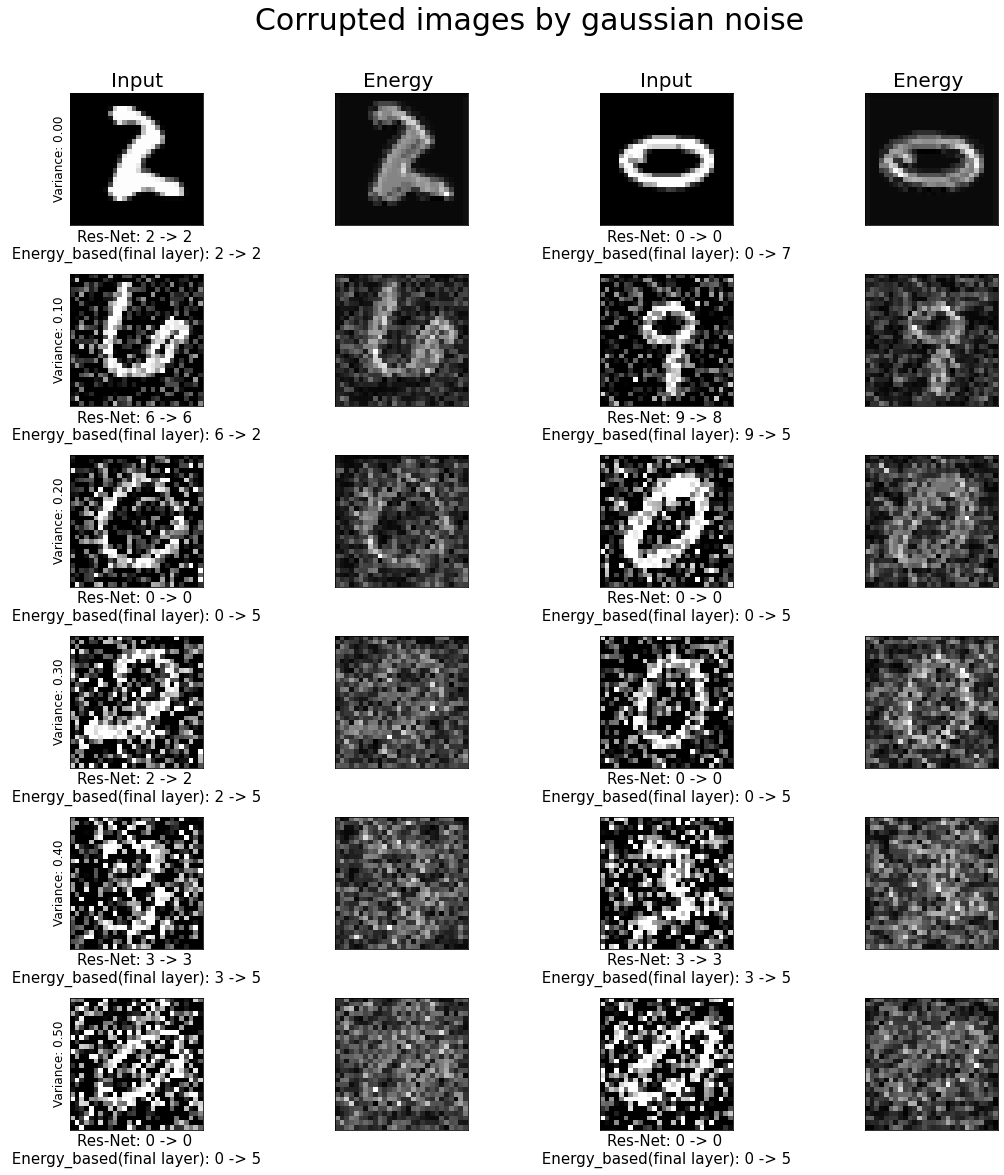

In [ ]:
plot_energy_noise(exp_gaussian_all, eng_gaussian_all, vars, Title="Corrupted images by gaussian noise", y_label="Variance", is_regular=0, model=models[1], targets=tgt_gaussian_all, preds=pre_gaussian_all)

6
1
6
3
2
7
6
1
2
5
2
3


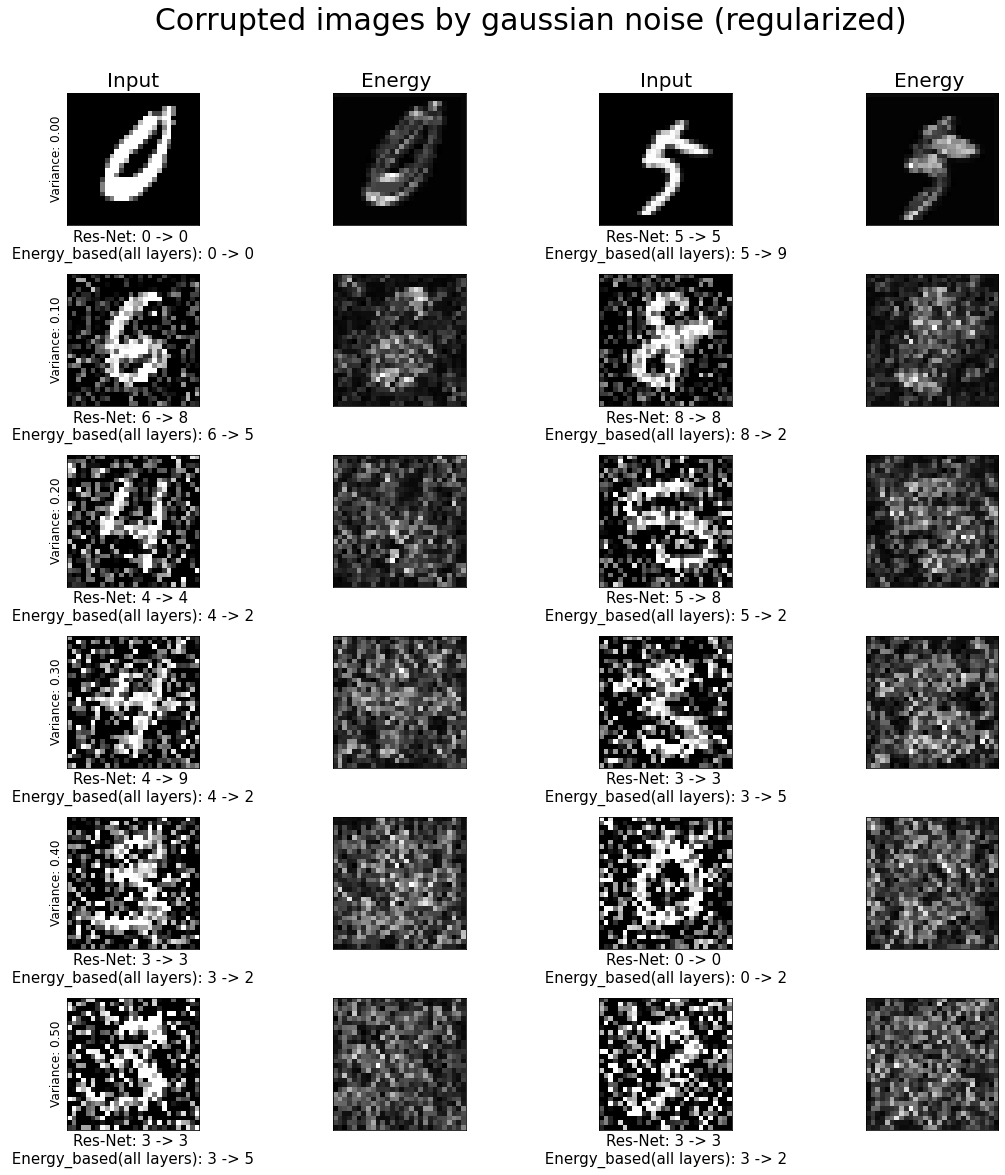

In [ ]:
plot_energy_noise(exp_gaussian_all, eng_gaussian_all, vars, Title="Corrupted images by gaussian noise (regularized)", y_label="Variance", is_regular=1, model=models[1], targets=tgt_gaussian_all, preds=pre_gaussian_all)

6
7
2
7
6
3
6
1
2
1
2
7


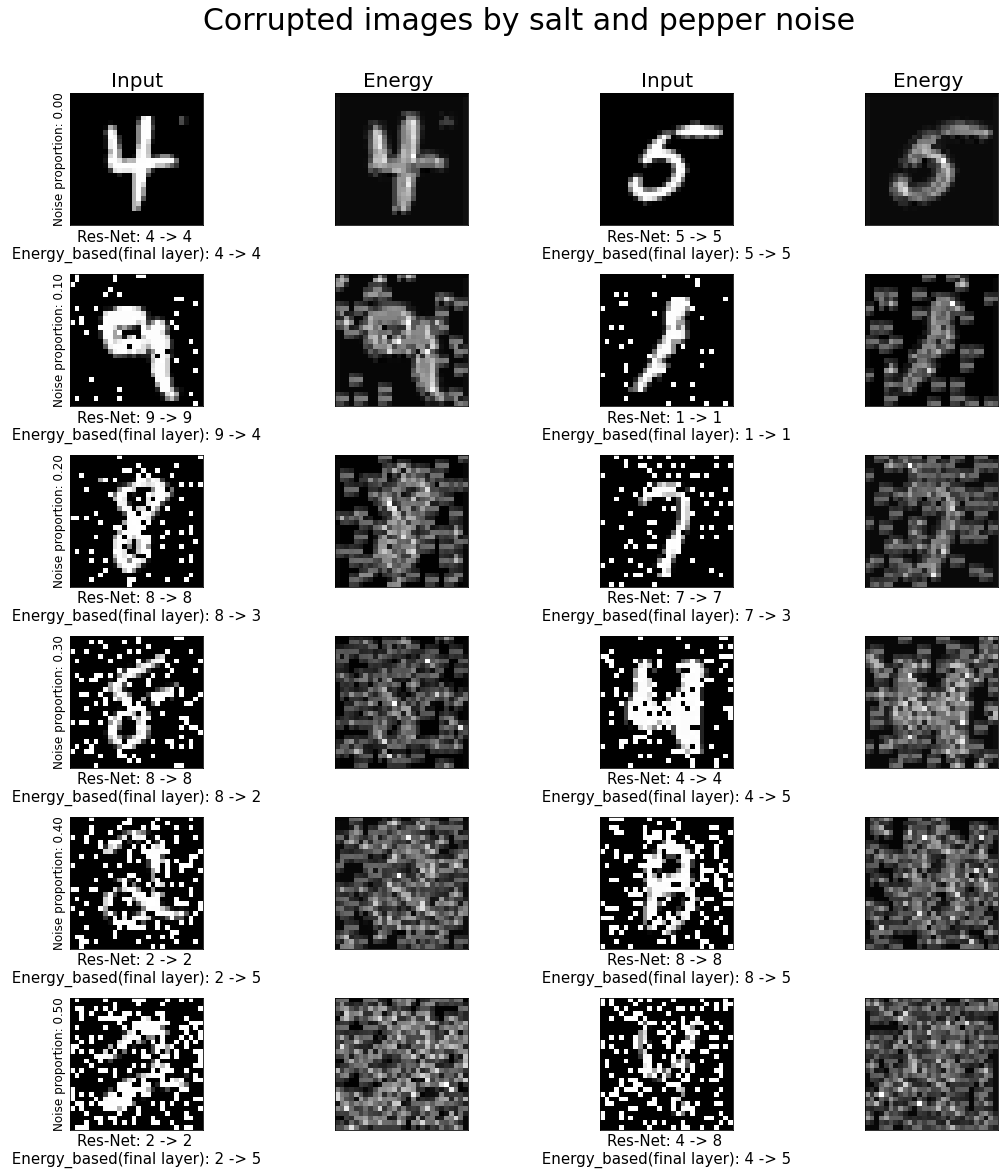

In [ ]:
plot_energy_noise(exp_salt_pepper_all, eng_salt_pepper_all, amounts, Title="Corrupted images by salt and pepper noise", y_label="Noise proportion", is_regular=0, model=models[1], targets=tgt_salt_pepper_all, preds=pre_salt_pepper_all)

6
7
4
7
6
1
6
7
2
1
4
7


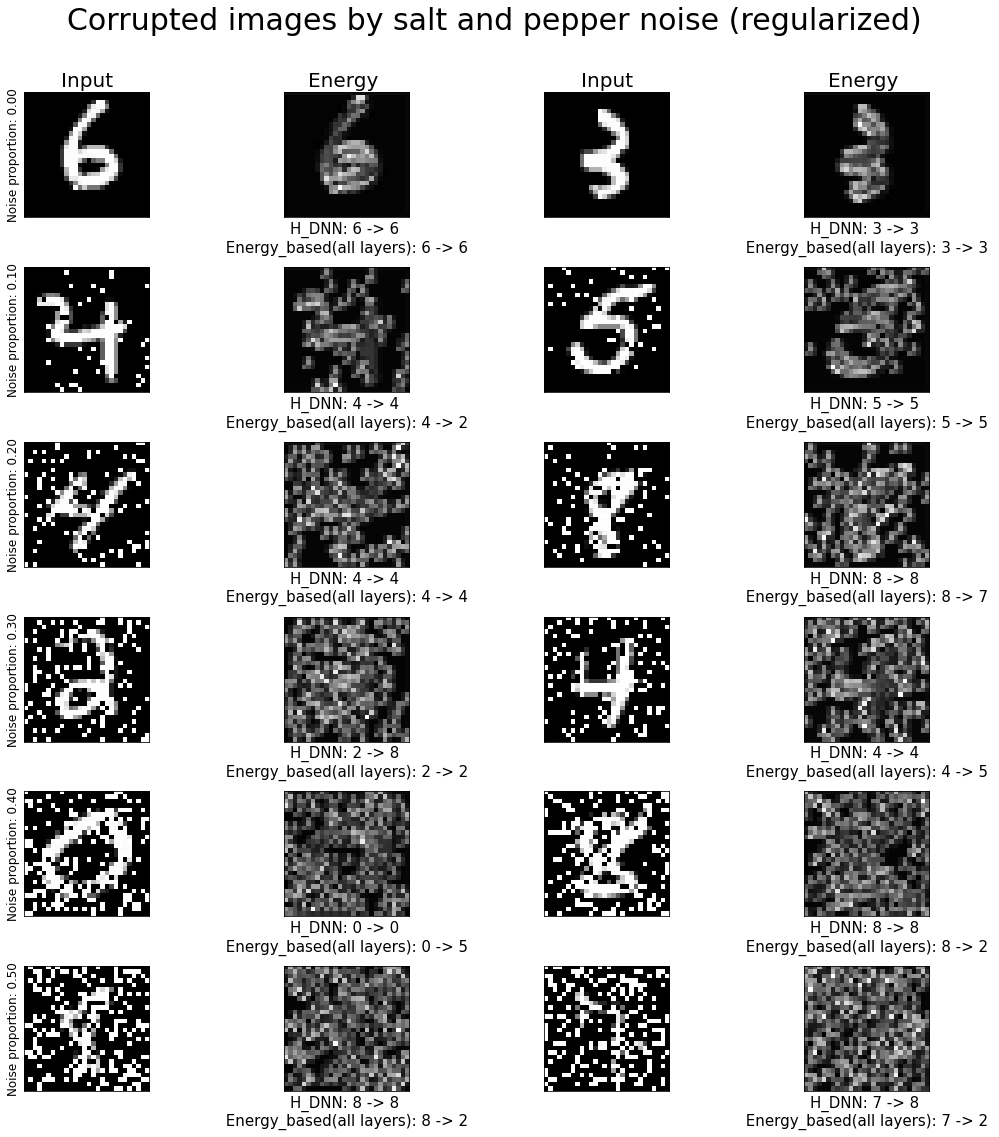

In [ ]:
plot_energy_noise(exp_salt_pepper_all, eng_salt_pepper_all, amounts, Title="Corrupted images by salt and pepper noise (regularized)", y_label="Noise proportion", is_regular=1, model=models[0], targets=tgt_salt_pepper_all, preds=pre_salt_pepper_all)

6
7
6
7
0
7
0
1
6
7
6
7


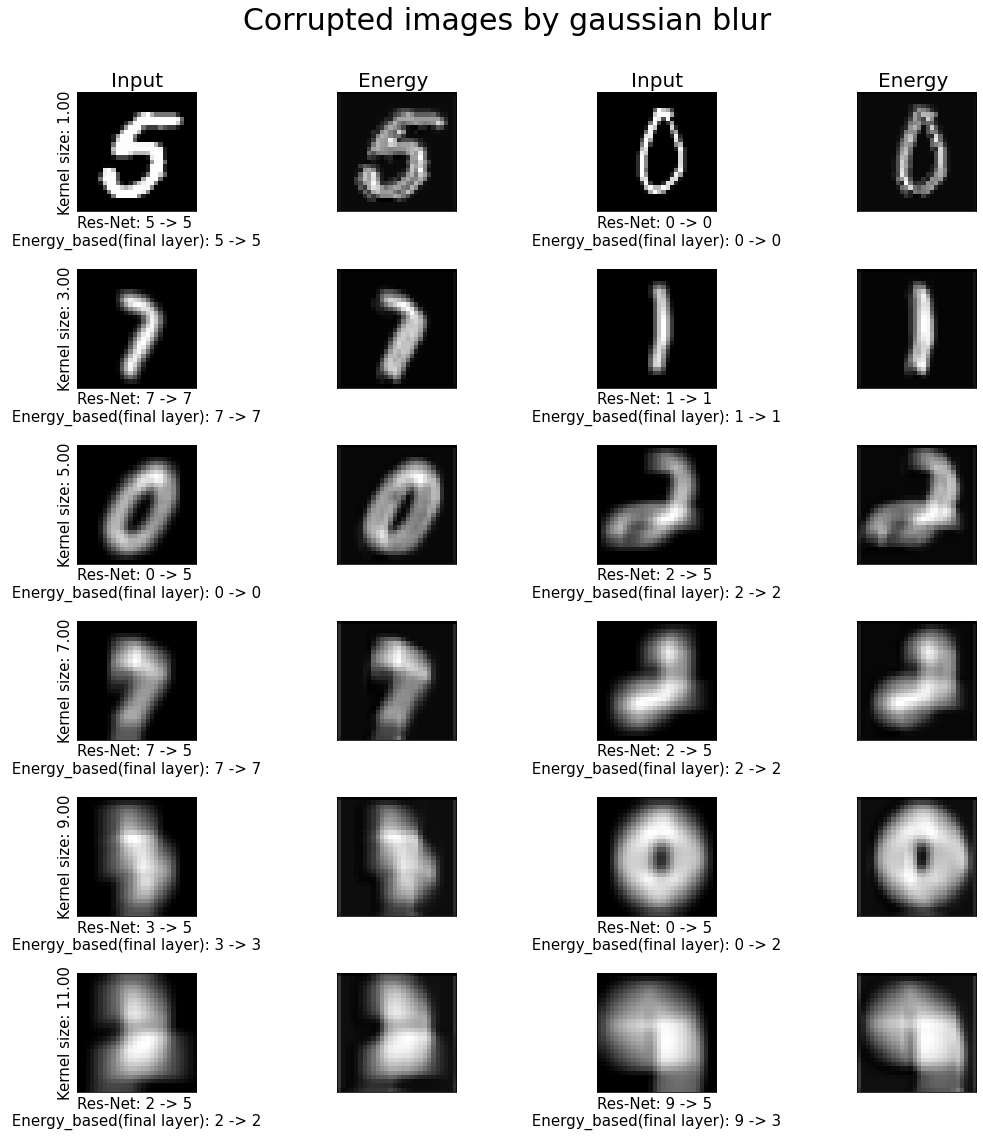

In [ ]:
plot_energy(exp_gaussian_blur_all, eng_gaussian_blur_all, kernel_sizes, Title="Corrupted images by gaussian blur", y_label="Kernel size", is_regular=0, model=models[1], targets=tgt_gaussian_blur_all, preds=pre_gaussian_blur_all)

6
7
6
7
0
7
6
7
6
7
0
7


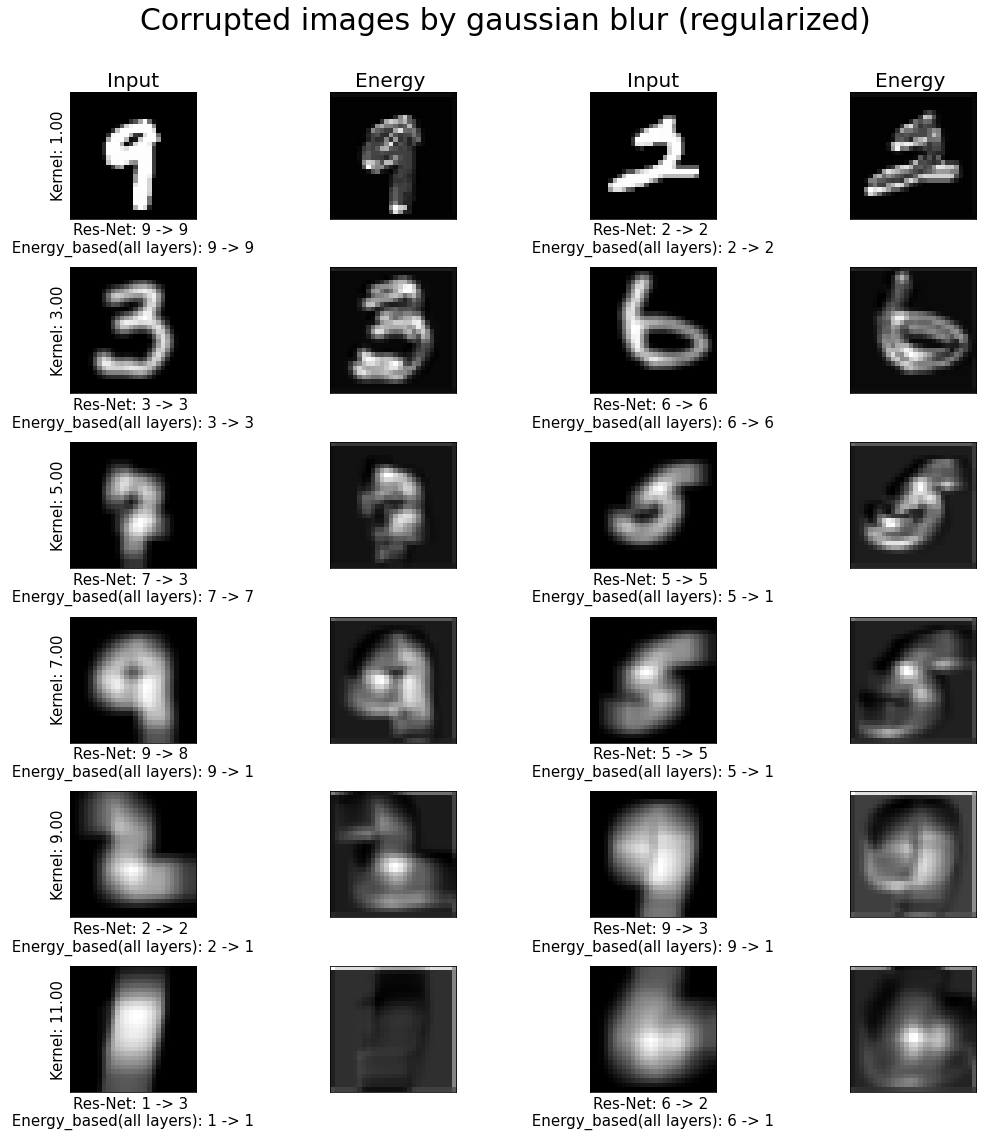

In [ ]:
plot_energy(exp_gaussian_blur_all, eng_gaussian_blur_all, kernel_sizes, Title="Corrupted images by gaussian blur (regularized)", y_label="Kernel", is_regular=1, model=models[0], targets=tgt_gaussian_blur_all, preds=pre_gaussian_blur_all)

In [ ]:
torch.max(exp_gaussian_blur_all[0][0][8])

## Plot Accuracy

In [25]:
def plot_accuracy(parameters, accuracies, Title, x_label, x_step):
  plt.figure(figsize=(10,10))
  plt.plot(parameters, accuracies[0], "*--", label='H-DNN')
  plt.plot(parameters, accuracies[1], "r*--", label='Res-Net')
  plt.plot(parameters, accuracies[2], "g*-", label='Final-state-energy-based')
  # plt.plot(parameters, accuracies[3], "b*-", label = 'Energy based (unrolled)')
  plt.plot(parameters, accuracies[3], "c*-", label = 'All-states-energy-based')
  # plt.plot(parameters, accuracies[5], "m*-", label = 'Energy based (all layers + states)')
  plt.yticks(np.arange(0, 1.1, step=0.1))
  plt.xticks(np.arange(0, max(parameters)+x_step, step=x_step))
  plt.title(Title,fontsize=20)
  plt.xlabel(x_label,fontsize=15)
  plt.ylabel("Accuracy",fontsize=15)
  plt.legend(fontsize=15)
  plt.show()

In [ ]:
acc_gaussian_all = torch.load("acc_gaussian_all.pt")
vars = np.linspace(0,1.5,8)

In [ ]:
acc_fgsm_all = torch.load("acc_fgsm_all.pt")
len(acc_fgsm_all)

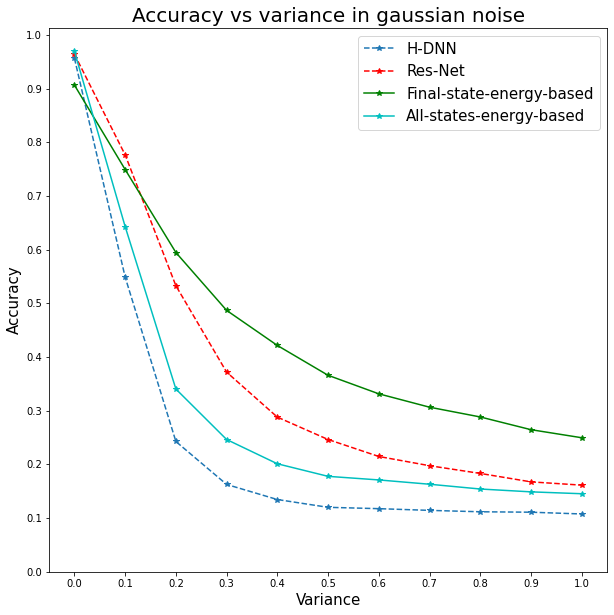

In [46]:
plot_accuracy(vars, acc_gaussian_all, Title="Accuracy vs variance in gaussian noise", x_label="Variance", x_step=0.1)

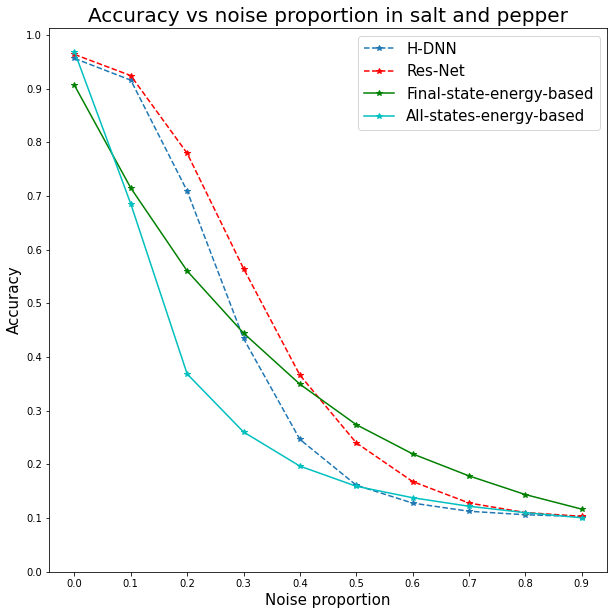

In [47]:
plot_accuracy(amounts, acc_salt_pepper_all, Title="Accuracy vs noise proportion in salt and pepper", x_label="Noise proportion",x_step=0.1)

In [ ]:
acc_gaussian_blur_all = torch.load("acc_gaussian_blur_all.pt")

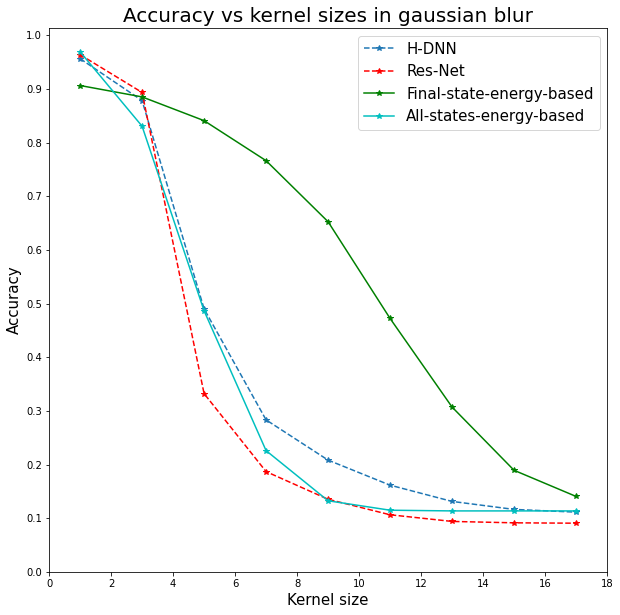

In [48]:
kernel_sizes = np.linspace(1,17,9)
plot_accuracy(kernel_sizes, acc_gaussian_blur_all, Title="Accuracy vs kernel sizes in gaussian blur", x_label="Kernel size",x_step=2)

## Save

In [ ]:
torch.save(acc_salt_pepper_all,"acc_salt_pepper_all.pt")
torch.save(exp_salt_pepper_all,"exp_salt_pepper_all.pt")
torch.save(eng_salt_pepper_all,"eng_salt_pepper_all.pt")
torch.save(tgt_salt_pepper_all,"tgt_salt_pepper_all.pt")
torch.save(pre_salt_pepper_all,"pre_salt_pepper_all.pt")

In [ ]:
torch.save(acc_gaussian_blur_all,"acc_gaussian_blur_all.pt")
torch.save(exp_gaussian_blur_all,"exp_gaussian_blur_all.pt")
torch.save(eng_gaussian_blur_all,"eng_gaussian_blur_all.pt")
torch.save(tgt_gaussian_blur_all,"tgt_gaussian_blur_all.pt")
torch.save(pre_gaussian_blur_all,"pre_gaussian_blur_all.pt")

In [ ]:
torch.save(acc_gaussian_all,"acc_gaussian_all.pt")
torch.save(exp_gaussian_all,"exp_gaussian_all.pt")
torch.save(eng_gaussian_all,"eng_gaussian_all.pt")
torch.save(tgt_gaussian_all,"tgt_gaussian_all.pt")
torch.save(pre_gaussian_all,"pre_gaussian_all.pt")

In [ ]:
torch.save(acc_gaussian_all,"acc/acc_gaussian_all.pt")

# Adversarial Attack

In [18]:
def test_fgsm(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = FGSM(model, eps=epsilon)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count > 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:100], H[0:100], target[0:100], pred[0:100]

In [ ]:
# def sample_fgsm(models, test_loader, epsilon):
#     cnt = 0
#     out_im = []
#     out_H = []
#     out_lab = []
#     out_pred = []
#     for data, target in test_loader:
#       count = 1
#       correct = []
#       pred_all = []
#       for model in models:
#         atk = FGSM(model, eps=epsilon)
#         data = data*0.3081 + 0.1307
#         im_data = atk(data, target)
#         im_data = (im_data-0.1307) / 0.3081
#         if count > 2:
#           H = model.getH()
#         else:
#           H = np.zeros(10)
#         output = model(im_data)
#         pred = output.argmax(dim=1, keepdim=True)
#         pred_all.append(pred)
#         count += 1
#         correct.append(pred.eq(target.view_as(pred)))
      
      
#       for i in range(1000):
#         if pred_all[0][i] != target[i] and pred_all[3][i] == target[i]:
#           out_im.append(im_data[i])
#           out_H.append(H[i])
#           out_lab.append(target[i])
#           out_pred.append(pred_all[0][i])
#           cnt += 1
#         if cnt > 4:
#           break
#       if cnt>4:
#         break
#       if len(out_im)<4:
#         out_im.append(im_data[])
#     return out_im, out_H, out_lab, out_pred

SyntaxError: ignored

In [ ]:
for data, target in test_loader:
  print(target[0])
  break

tensor(1)


In [29]:
def test_pgd(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = PGD(model, eps=epsilon, alpha=0.1, steps=7)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count > 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:100], H[0:100], target[0:100], pred[0:100]

In [ ]:
def test_pgdl2(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = PGDL2(model, eps=epsilon, steps=7, alpha=0.1)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count > 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [49]:
epsilons_fgsm = np.linspace(0,0.5,11)
acc_fgsm_all = []
exp_fgsm_all = []
eng_fgsm_all = []
tgt_fgsm_all = []
pre_fgsm_all = []
count = 0

example_img_all = []

for model in models:
  print(model)
  count += 1
  acc_fgsm=[]
  exp_fgsm=[]
  eng_fgsm=[]
  tgt_fgsm=[]
  pre_fgsm=[]
  for epsilon in epsilons_fgsm:
    test_acc, examples, energy, target, pred = test_fgsm(model, device, test_loader, out, epsilon, count)
    acc_fgsm.append(test_acc)
    exp_fgsm.append(examples)
    eng_fgsm.append(energy)
    tgt_fgsm.append(target)
    pre_fgsm.append(pred)
  acc_fgsm_all.append(acc_fgsm)
  exp_fgsm_all.append(exp_fgsm)
  eng_fgsm_all.append(eng_fgsm)
  tgt_fgsm_all.append(tgt_fgsm)
  pre_fgsm_all.append(pre_fgsm)

Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=6272, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.1380, Accuracy:  9566/10000 (95.66%)
Epsilon:0.050 Average loss: 0.8360, Accuracy:  7364/10000 (73.64%)
Epsilon:0.100 Average loss: 5.4372, Accuracy:   916/10000 (9.16%)
Epsilon:0.150 Average loss: 12.9680, Accuracy:     2/10000 (0.02%)
Epsilon:0.200 Average loss: 19.7827, Accuracy:     0/10000 (0.00%)
Epsilon:0.250 Average loss: 25.0224, Accuracy:     0/10000 (0.00%)
Epsilon:0.300 Average loss: 28.6410, Accuracy:     0/10000 (0.00%)
Epsilon:0.350 Average loss: 30.8512, Accuracy:     0/10000 (0.00%)
Epsilon:0.400 Average loss: 31.9136, Accuracy:     0/10000 (0.00%)
Epsilon:0.450 Average loss: 32.0591, Accuracy:     0/10000 (0.00%)
Epsilon:0.500 Average loss: 31.4769, Accuracy:     0/10000 (0.00%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), 

In [ ]:
# exp_fgsm_2 = []
# eng_fgsm_2 = []
# tgt_fgsm_2 = []
# pre_fgsm_2 = []
# for epsilon in epsilons_fgsm:
#   examples, energy, target, predict = sample_fgsm(models, test_loader, epsilon)
#   exp_fgsm_2.append(examples)
#   eng_fgsm_2.append(energy)
#   tgt_fgsm_2.append(target)
#   pre_fgsm_2.append(predict)

NameError: ignored

In [ ]:
# def plot_energy(examples, energy, parameters, Title, y_label, is_regular, target, prediction):
#   n_data = 2
#   if is_regular:
#     n_data = 3
#   fig = plt.figure(figsize=(15,15))
#   cnt = 0
#   # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
#   for i in range(6): #6
#       for j in range(2):
#         cnt += 1
#         ax = fig.add_subplot(6, 4, 2*cnt-1)
#         # ax.axis('off')
#         # plt.subplot(5,10,2*cnt-1)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         if j == 0:
#           ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=15)
#         ex = examples[n_data][i][j]
#         ax.imshow(ex.squeeze(0), cmap="gray")
#         if i<1:
#           ax.set_title('Input', fontsize=20)

#         # plt.subplot(5,10,2*cnt)
#         ax = fig.add_subplot(6,4,2*cnt)
#         # plt.xticks([], [])
#         # plt.yticks([], [])
#         ax.axis('off')
#         H = energy[n_data][i][j]
#         ax.imshow(H.data.numpy().T, cmap="gray")
#         if i<1:
#           ax.set_title('Energy', fontsize=20)
#   plt.tight_layout()
#   # plt.subplots_adjust( 
#   #           wspace=0.1, 
#   #           hspace=-0.7)
#   plt.suptitle(Title,fontsize = 30,y=1.05)
#   plt.show()

In [ ]:
pre_fgsm_2

In [ ]:
tgt_fgsm_2

In [ ]:
plt.imshow(eng_fgsm_2[0][0].data.numpy().T, cmap="gray")

In [36]:
np.linspace(0,0.25,6)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25])

In [50]:
epsilons_pgd = np.linspace(0,0.25,11)
acc_pgd_all = []
exp_pgd_all = []
eng_pgd_all = []
tgt_pgd_all = []
pre_pgd_all = []
count = 0
for model in models:
  print(model)
  count += 1
  acc_pgd=[]
  exp_pgd=[]
  eng_pgd=[]
  tgt_pgd=[]
  pre_pgd=[]
  for epsilon in epsilons_pgd:
    test_acc, examples, energy, target, pred = test_pgd(model, device, test_loader, out, epsilon, count)
    acc_pgd.append(test_acc)
    exp_pgd.append(examples)
    eng_pgd.append(energy)
    tgt_pgd.append(target)
    pre_pgd.append(pred)
  acc_pgd_all.append(acc_pgd)
  exp_pgd_all.append(exp_pgd)
  eng_pgd_all.append(eng_pgd)
  tgt_pgd_all.append(tgt_pgd)
  pre_pgd_all.append(pre_pgd)

Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=6272, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.1380, Accuracy:  9566/10000 (95.66%)
Epsilon:0.025 Average loss: 0.2949, Accuracy:  9109/10000 (91.09%)
Epsilon:0.050 Average loss: 0.7919, Accuracy:  7478/10000 (74.78%)
Epsilon:0.075 Average loss: 2.3589, Accuracy:  3668/10000 (36.68%)
Epsilon:0.100 Average loss: 5.4543, Accuracy:   893/10000 (8.93%)
Epsilon:0.125 Average loss: 9.4235, Accuracy:    52/10000 (0.52%)
Epsilon:0.150 Average loss: 13.5603, Accuracy:     5/10000 (0.05%)
Epsilon:0.175 Average loss: 17.5283, Accuracy:     0/10000 (0.00%)
Epsilon:0.200 Average loss: 21.2233, Accuracy:     0/10000 (0.00%)
Epsilon:0.225 Average loss: 24.6018, Accuracy:     0/10000 (0.00%)
Epsilon:0.250 Average loss: 27.6734, Accuracy:     0/10000 (0.00%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
# epsilons_pgdl2 = np.linspace(0,2,6)
# acc_pgdl2_all = []
# exp_pgdl2_all = []
# eng_pgdl2_all = []
# count = 0
# for model in models:
#   print(model)
#   count += 1
#   acc_pgdl2=[]
#   exp_pgdl2=[]
#   eng_pgdl2=[]
#   for epsilon in epsilons_pgdl2:
#     test_acc, examples, energy = test_pgdl2(model, device, test_loader, out, epsilon, count)
#     acc_pgdl2.append(test_acc)
#     exp_pgdl2.append(examples)
#     eng_pgdl2.append(energy)
#   acc_pgdl2_all.append(acc_pgdl2)
#   exp_pgdl2_all.append(exp_pgdl2)
#   eng_pgdl2_all.append(eng_pgdl2)

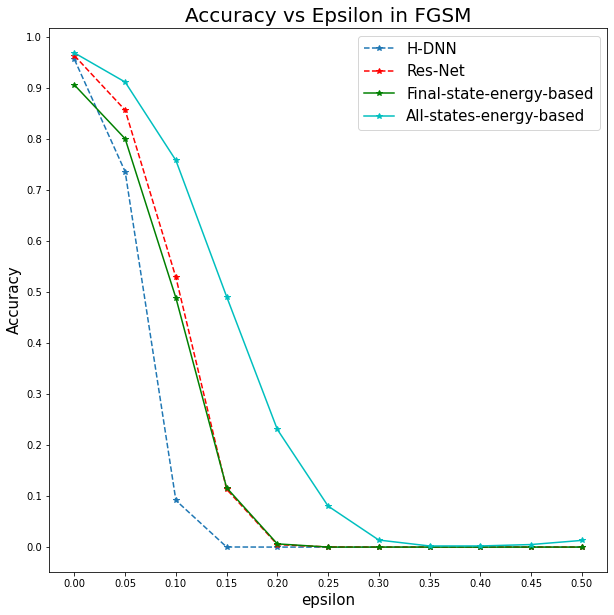

In [51]:
# epsilons_fgsm = np.linspace(0,0.5,11)
plot_accuracy(epsilons_fgsm, acc_fgsm_all, Title="Accuracy vs Epsilon in FGSM", x_label="epsilon",x_step=0.05)

In [ ]:
acc_pgd_all = torch.load("acc_pgd_all.pt")

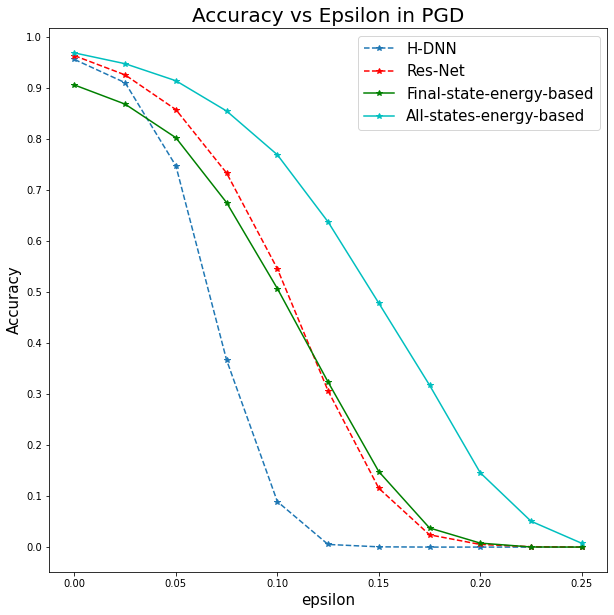

In [52]:
plot_accuracy(epsilons_pgd, acc_pgd_all, Title="Accuracy vs Epsilon in PGD", x_label="epsilon",x_step=0.05)

## Plot energy

In [57]:
def plot_energy_attack(examples, energy, parameters, Title, y_label, is_regular, model, targets, preds):
  n_data = 2
  if is_regular:
    n_data = 3
  fig = plt.figure(figsize=(15,15))
  cnt = 0
  # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
  for i in range(6): #6
      i= i*2
      for j0 in range(2):
        cnt += 1
        for k in range(int(len(targets[n_data][i])/2)):
        # for k in range(5):
          j = 2*k + j0
          ex = examples[n_data][i][j]

          output = model(ex.unsqueeze(0))
          pred_0 = output.argmax(dim=1, keepdim=True)

          if pred_0 !=targets[n_data][i][j] and preds[n_data][i][j] == targets[n_data][i][j]:
            break

        
        print(j)
        ex = examples[n_data][i][j]

        output = model(ex.unsqueeze(0))
        pred_0 = output.argmax(dim=1, keepdim=True)

        

        ax = fig.add_subplot(6, 4, 2*cnt-1)
        # ax.axis('off')
        # plt.subplot(5,10,2*cnt-1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j0 == 0:
          ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=15)
        

        ax.imshow(ex.squeeze(0), cmap="gray")
        if i<1:
          ax.set_title('Input', fontsize=20)
        if is_regular:
          ax.set_xlabel("Res-Net: {} -> {} \n Energy_based(all layers): {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)
        else:
          ax.set_xlabel("Res-Net: {} -> {} \n Energy_based(final layer): {} -> {} ".format(targets[n_data][i][j], pred_0.numpy()[0][0], targets[n_data][i][j], preds[n_data][i][j].numpy()[0]),fontsize=15)


        # plt.subplot(5,10,2*cnt)
        ax = fig.add_subplot(6,4,2*cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        # ax.axis('off')
        H = energy[n_data][i][j]
        ax.imshow(H.data.numpy().T, cmap="gray")
        if i<1:
          ax.set_title('Energy ',fontsize=20)
        
  plt.tight_layout()
  # plt.subplots_adjust( 
  #           wspace=0.1, 
  #           hspace=-0.7)
  plt.suptitle(Title,fontsize = 30,y=1.05)
  plt.show()

98
11
98
17
98
99
98
99
98
99
98
99


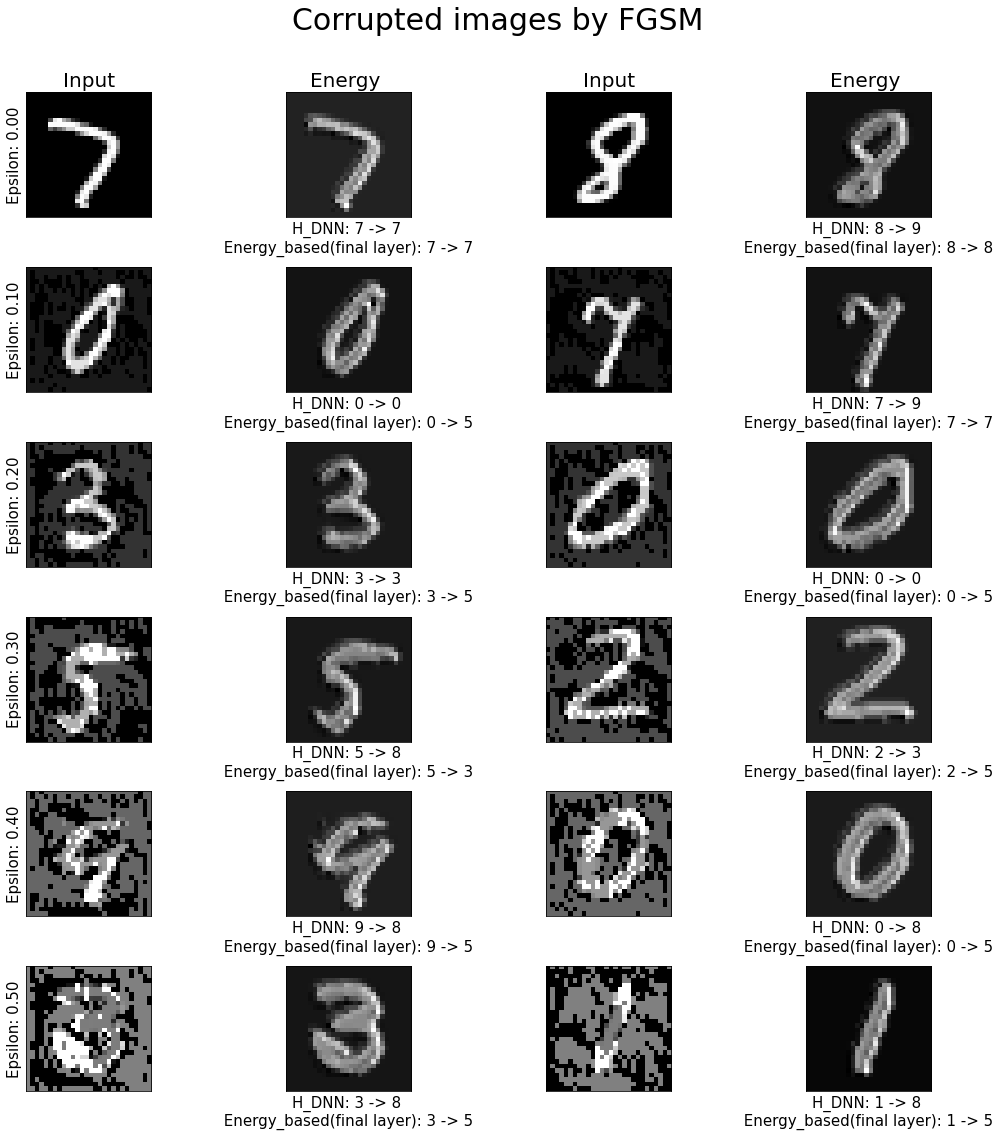

In [ ]:
plot_energy(exp_fgsm_all, eng_fgsm_all, epsilons_fgsm, Title="Corrupted images by FGSM", y_label="Epsilon", is_regular=0, model=models[0], targets=tgt_fgsm_all, preds=pre_fgsm_all)

In [ ]:
exp_fgsm_all[0][4][0][0][0,0]

0
99
24
57
12
5
60
9
98
99
98
99


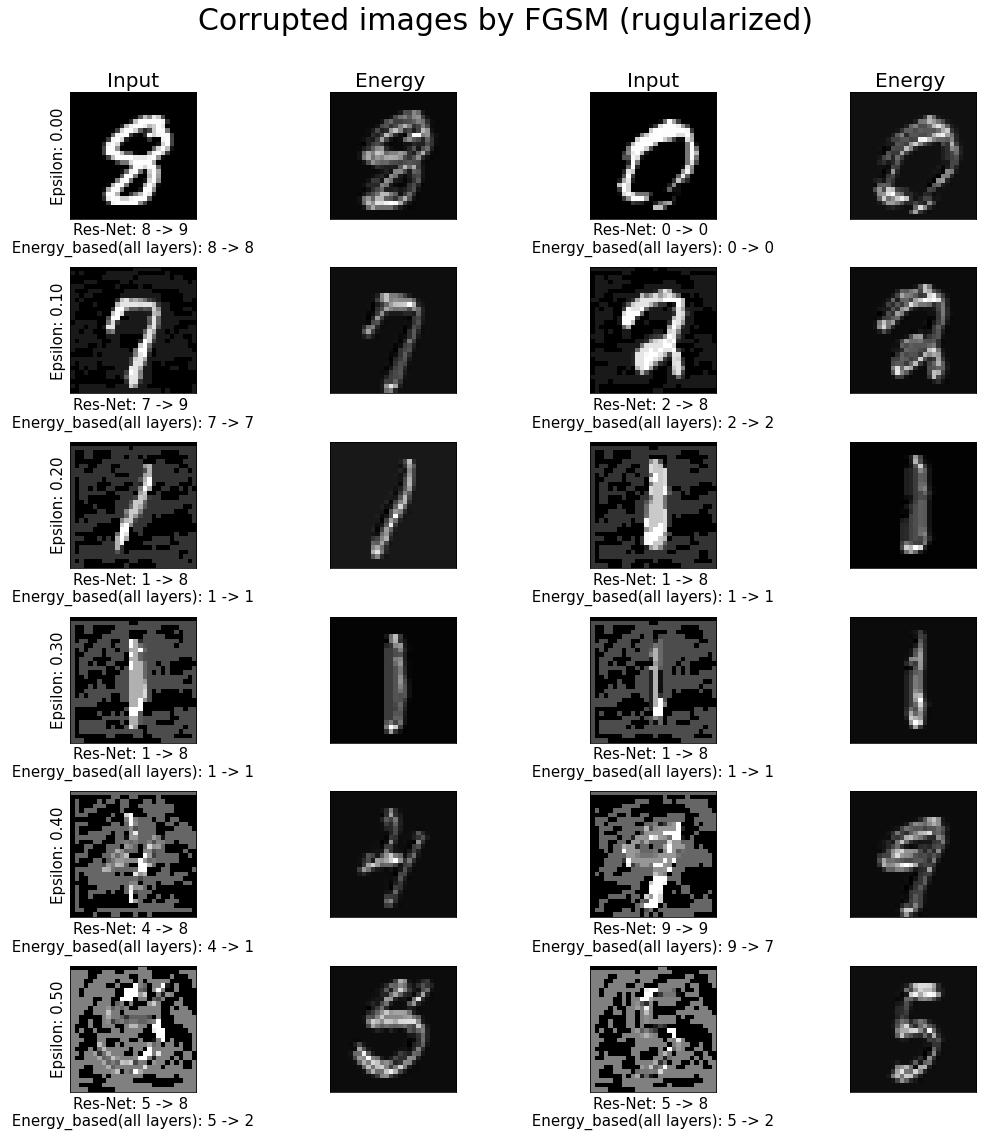

In [58]:
plot_energy_attack(exp_fgsm_all, eng_fgsm_all, epsilons_fgsm, Title="Corrupted images by FGSM (rugularized)", y_label="Epsilon", is_regular=1, model=models[0], targets=tgt_fgsm_all, preds=pre_fgsm_all)

98
65
88
69
98
99
22
99
98
99
98
99


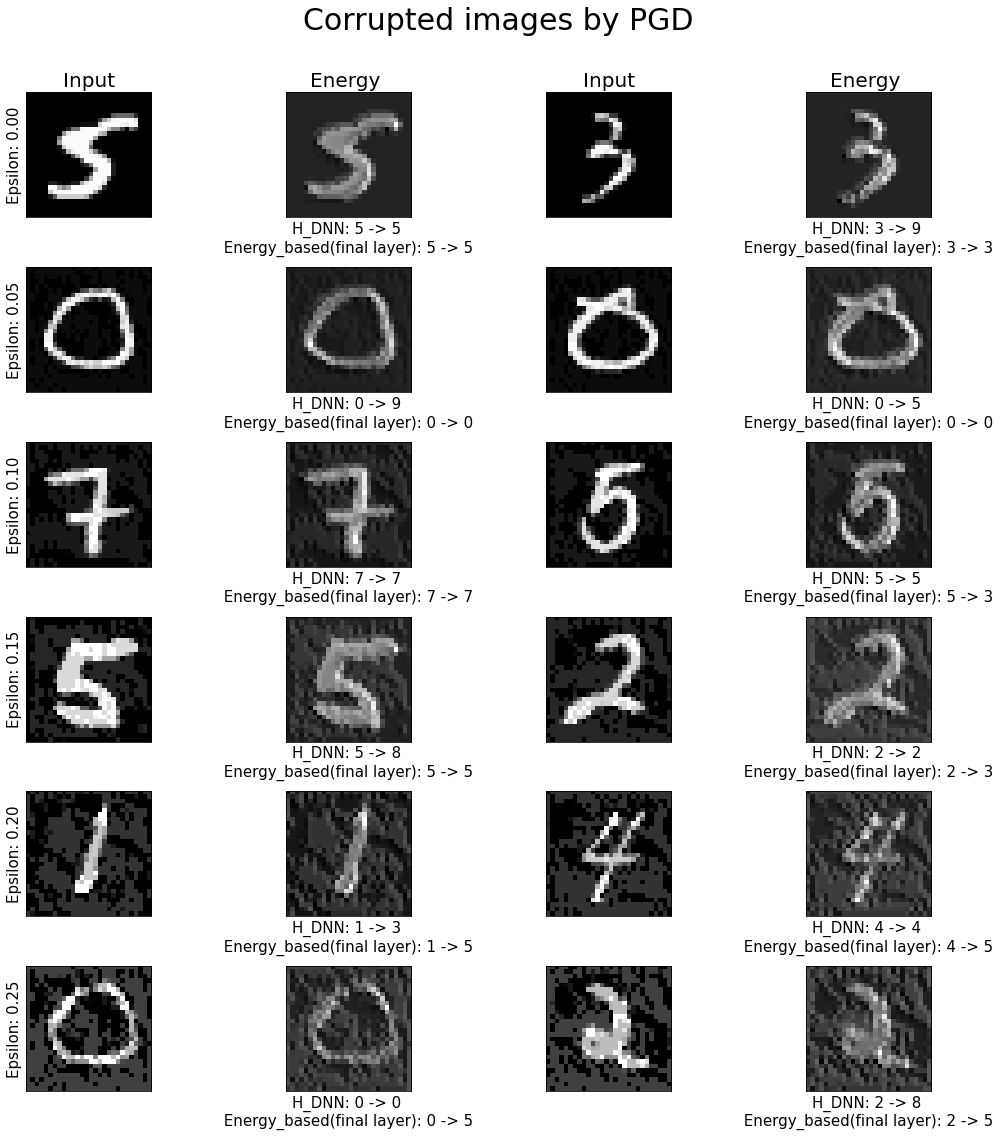

In [ ]:
plot_energy(exp_pgd_all, eng_pgd_all, epsilons_pgd, Title="Corrupted images by PGD", y_label="Epsilon", is_regular=0, model=models[0], targets=tgt_pgd_all, preds=pre_pgd_all)

52
45
98
99
28
99
32
3
4
19
98
99


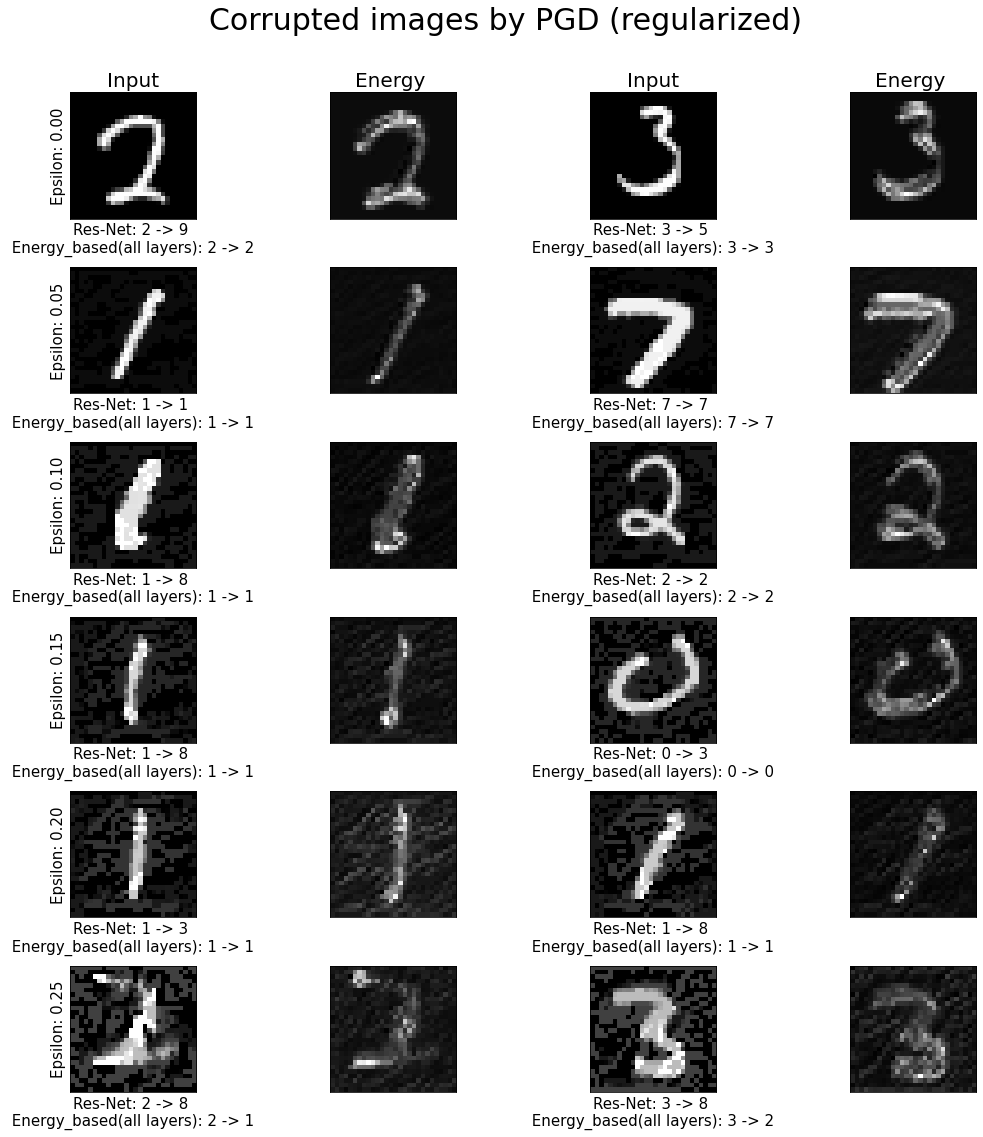

In [59]:
plot_energy_attack(exp_pgd_all, eng_pgd_all, epsilons_pgd, Title="Corrupted images by PGD (regularized)", y_label="Epsilon", is_regular=1, model=models[0], targets=tgt_pgd_all, preds=pre_pgd_all)

In [ ]:
for data, target in test_loader:
  print(data[0].shape)
  break

In [ ]:
a = data[0].reshape(-1,28*28)

In [ ]:
b = data[0].ravel()

In [ ]:
a[0,200:250]

In [ ]:
plt.imshow(exp_fgsm_all[1][5][0].squeeze(0), cmap="gray")

In [ ]:
plt.imshow(exp_pgd_all[1][5][2].squeeze(0), cmap="gray")

In [ ]:
plt.imshow(exp_pgd_all[0][5][3].squeeze(0), cmap="gray")

## Save

In [ ]:
from google.colab import files
files.download("exp_fgsm_all.pt")
files.download("exp_pgd_all.pt")
files.download("exp_gaussian_all.pt")
files.download("exp_gaussian_blur_all.pt")
files.download("exp_salt_pepper_all.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("eng_fgsm_all.pt")
files.download("eng_pgd_all.pt")
files.download("eng_gaussian_all.pt")
files.download("eng_gaussian_blur_all.pt")
files.download("eng_salt_pepper_all.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(acc_fgsm_all,"acc/acc_fgsm_all.pt")

In [ ]:
torch.save(acc_pgd_all,"acc_pgd_all.pt")
torch.save(exp_pgd_all,"exp_pgd_all.pt")
torch.save(eng_pgd_all,"eng_pgd_all.pt")

In [ ]:
torch.save(tgt_pgd_all,"tgt_pgd_all.pt")
torch.save(pre_pgd_all,"pre_pgd_all.pt")


In [ ]:
torch.save(acc_fgsm_all,"acc_fgsm_all.pt")
torch.save(exp_fgsm_all,"exp_fgsm_all.pt")
torch.save(eng_fgsm_all,"eng_fgsm_all.pt")

In [ ]:
torch.save(tgt_fgsm_all,"tgt_fgsm_all.pt")
torch.save(pre_fgsm_all,"pre_fgsm_all.pt")

In [ ]:
files.download("exp_fgsm_all.pt")
files.download("exp_pgd_all.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("eng_fgsm_all.pt")
files.download("eng_pgd_all.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("tgt_fgsm_all.pt")
files.download("tgt_pgd_all.pt")
files.download("pre_fgsm_all.pt")
files.download("pre_pgd_all.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pre_pgd_all[0][0].shape

torch.Size([100, 1])